# GKO Synthetic Experiment

In this experiment, we are testing the performance of following methods: GK, GKO, and MWRKO. Iteration and CPU are measured for different types of system including the following:

* System with two set of correlated systems

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from time import process_time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import math
from numpy.random import default_rng
from sklearn.preprocessing import normalize

In [2]:
# importing algorithm functions
import sys
sys.path.insert(1, '/Users/jennytran/Documents/GitHub/gko-23/scripts/functions')
from method import method

### Generate System

In [3]:
# Generate system
# Step 1: generate two gaussian linear system
A = np.random.randn(2,500)
A1 = np.reshape(A[0,:], (1, 500))
A2 = np.reshape(A[1,:], (1, 500))

In [4]:
# Step 2: generate correalted systems
U = np.random.uniform(low = -1, high = 1, size  = (2500,500))
A1 = np.tile(A1, (2500, 1)) + U
A2 = np.tile(A2, (2500, 1)) + U

In [5]:
# Step 3: Combine two correlated systems
A = np.concatenate((A1, A2))
x = np.ones(500)
y = A @ x

### Run Experiments

In [6]:
# gk
gk_start_cyclic_corr = process_time()
gk_corr = method(A,x,y,'GK', 0.5*10**-8)
gk_stop_cyclic_corr = process_time()
# gko
gko_start_cyclic_corr = process_time()
gko_corr = method(A,x,y,'GKO', 0.5*10**-8)
gko_stop_cyclic_corr = process_time()
# mwrko
mwrko_start_cyclic_corr = process_time()
mwrko_corr = method(A,x,y,'MWRKO', 0.5*10**-8)
mwrko_stop_cyclic_corr = process_time()

In [7]:
# cpu data
gk_cpu_corr = gk_stop_cyclic_corr - gk_start_cyclic_corr
gko_cpu_corr = gko_stop_cyclic_corr - gko_start_cyclic_corr
mwrko_cpu_corr = mwrko_stop_cyclic_corr - mwrko_start_cyclic_corr

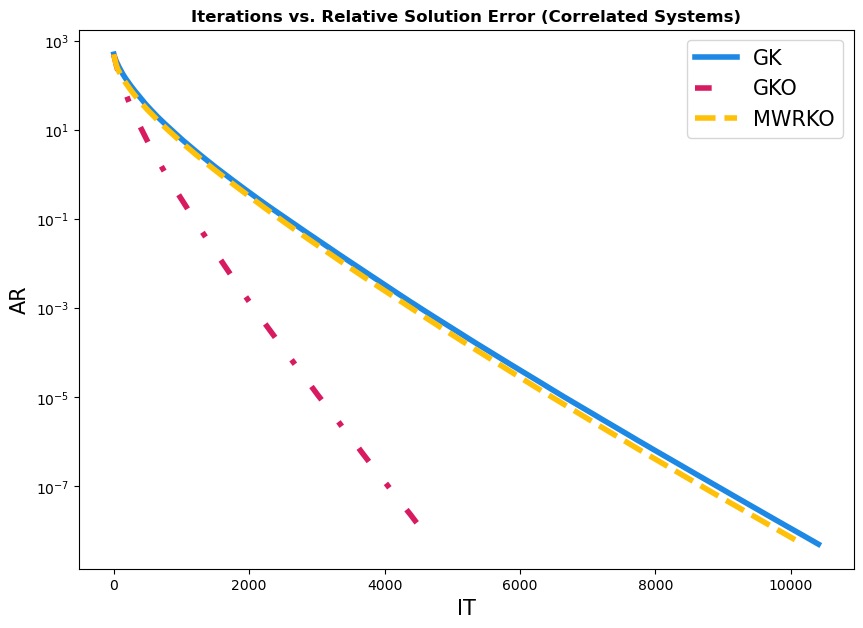

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure(figsize=(10,7))

plt.semilogy(np.arange(gk_corr[0]), gk_corr[1], 
             color = '#1E88E5', linewidth = 4, linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_corr[0]), gko_corr[1],
            color = '#D81B60', linewidth = 4, linestyle = (0, (3, 5, 1, 5)), label = 'GKO')
plt.semilogy(np.arange(mwrko_corr[0]), mwrko_corr[1],
            color = '#FFC107', linewidth = 4, linestyle = 'dashed', label = 'MWRKO')

plt.xlabel('IT', fontsize = 15)
plt.ylabel('AR', fontsize = 15)
plt.title('Iterations vs. Relative Solution Error (Correlated Systems)', fontweight="bold")
plt.legend(fontsize="15")
plt.show()
plt.savefig('../../outputs/synthetic-exp/5000x500/iter/5000-corr-iter.png')

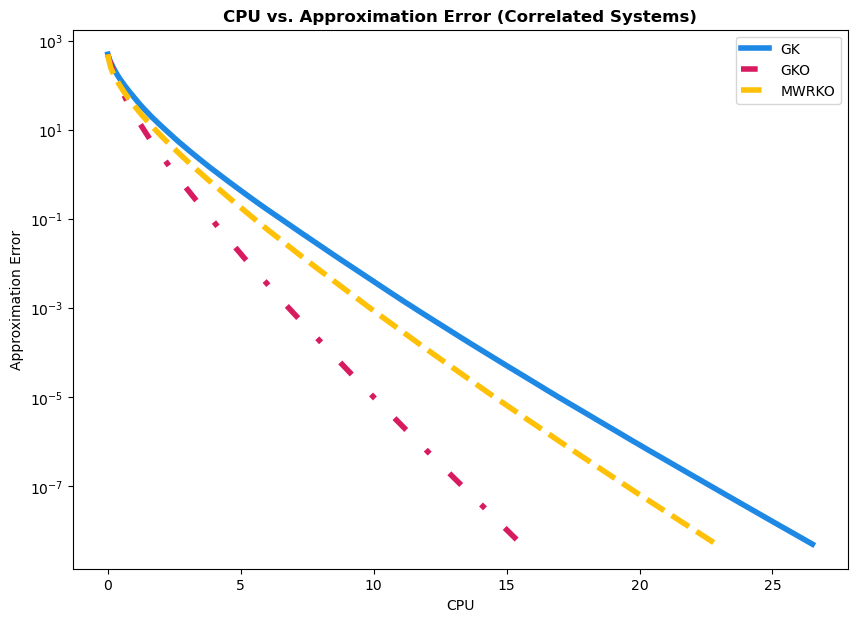

In [9]:
plt.figure(figsize=(10,7))

plt.semilogy(np.linspace(0,gk_cpu_corr,gk_corr[0]), gk_corr[1],
            color = '#1E88E5', linewidth = 4, linestyle = 'solid', label = 'GK')
plt.semilogy(np.linspace(0,gko_cpu_corr,gko_corr[0]), gko_corr[1],
            color = '#D81B60', linewidth = 4, linestyle = (0, (3, 5, 1, 5)), label = 'GKO')
plt.semilogy(np.linspace(0,mwrko_cpu_corr,mwrko_corr[0]), mwrko_corr[1],
            color = '#FFC107', linewidth = 4, linestyle = 'dashed', label = 'MWRKO')

plt.xlabel('CPU')
plt.ylabel('Approximation Error')
plt.title('CPU vs. Approximation Error (Correlated Systems)',  fontweight="bold")
plt.legend(fontsize="15")
plt.legend()
plt.savefig('../../outputs/synthetic-exp/5000x500/iter/5000-corr-cpu.png')

## Experiment 2: Testing Different Correlated Systems

We will test the performance of our methods using different lowerbounds c, which determines how correlated systems are.

In [10]:
c = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ]
gk_iter = []
gko_iter = []
mwrko_iter = []
gk_cpulst = []
gko_cpulst = []
mwrko_cpulst = []

for bd in c:
    print(bd)
    # Generate system
    # Step 1: generate two gaussian linear system
    A = np.random.randn(2,500)
    A1 = np.reshape(A[0,:], (1, 500))
    A2 = np.reshape(A[1,:], (1, 500))
    # Step 2: generate correalted systems
    U = np.random.uniform(low = -bd, high = bd, size  = (2500,500))
    A1 = np.tile(A1, (2500, 1)) + U
    A2 = np.tile(A2, (2500, 1)) + U
    # Step 3: Combine two correlated systems
    A = np.concatenate((A1, A2))
    x = np.ones(500)
    y = A @ x
    
    # Run algorithms
    # gk
    gk_start_cyclic = process_time()
    gk_corr = method(A,x,y,'GK', 0.5*10**(-8))
    gk_stop_cyclic = process_time()
    # gko
    gko_start_cyclic = process_time()
    gko_corr = method(A,x,y,'GKO', 0.5*10**(-8))
    gko_stop_cyclic = process_time()
    # mwrko
    mwrko_start_cyclic = process_time()
    mwrko_corr = method(A,x,y,'MWRKO', 0.5*10**(-8))
    mwrko_stop_cyclic = process_time()
    
    # cpu data
    gk_cpu = gk_stop_cyclic - gk_start_cyclic
    gko_cpu = gko_stop_cyclic - gko_start_cyclic
    mwrko_cpu = mwrko_stop_cyclic - mwrko_start_cyclic
    
    #append
    gk_iter.append(gk_corr[0])
    gko_iter.append(gko_corr[0])
    mwrko_iter.append(mwrko_corr[0])
    gk_cpulst.append(gk_cpu)
    gko_cpulst.append(gko_cpu)
    mwrko_cpulst.append(mwrko_cpu)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [11]:
df_iter = pd.DataFrame()
df_iter['c'] = c
df_iter['GK'] = gk_iter
df_iter['GKO'] = gko_iter
df_iter['MWRKO'] = mwrko_iter
df_iter

,c,GK,GKO,MWRKO
0,0.1,100000,5267,100000
1,0.2,100000,5461,100000
2,0.3,90677,5692,86638
3,0.4,51276,5457,47201
4,0.5,30584,5095,29971
5,0.6,25421,5118,24486
6,0.7,18330,5128,19120
7,0.8,13864,4498,13349
8,0.9,12504,4868,12679
9,1.0,11242,4977,11201


In [12]:
df_cpu = pd.DataFrame()
df_cpu['c'] = c
df_cpu['GK'] = gk_cpulst
df_cpu['GKO'] = gko_cpulst
df_cpu['MWRKO'] = mwrko_cpulst
df_cpu

,c,GK,GKO,MWRKO
0,0.1,219.950346,15.128854,242.095289
1,0.2,211.453211,16.935081,219.200139
2,0.3,199.684422,19.175916,199.124972
3,0.4,108.442866,16.628663,110.784401
4,0.5,63.712937,18.908666,65.764588
5,0.6,54.002098,16.270781,52.474943
6,0.7,37.881573,17.853522,41.656843
7,0.8,28.307559,14.527731,29.680554
8,0.9,29.648045,15.237210,28.037419
9,1.0,23.088455,15.776598,28.567020
